# Loop 84 Analysis: CV-LB Relationship and Strategy Assessment

**Critical Situation:**
- 84 experiments completed
- Best CV: 0.008092 (exp_049)
- Best LB: 0.0877 (exp_030)
- Target: 0.0347
- Gap: 152.8%

**Key Question:** How do we break the CV-LB line (LB = 4.29*CV + 0.0528)?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Submission history (CV, LB) pairs
submissions = [
    ('exp_000', 0.0111, 0.0982),
    ('exp_001', 0.0123, 0.1065),
    ('exp_003', 0.0105, 0.0972),
    ('exp_005', 0.0104, 0.0969),
    ('exp_006', 0.0097, 0.0946),
    ('exp_007', 0.0093, 0.0932),
    ('exp_009', 0.0092, 0.0936),
    ('exp_012', 0.0090, 0.0913),
    ('exp_024', 0.0087, 0.0893),
    ('exp_026', 0.0085, 0.0887),
    ('exp_030', 0.0083, 0.0877),
    ('exp_035', 0.0098, 0.0970),
    # exp_073 is an outlier (similarity weighting backfired)
    ('exp_073', 0.0084, 0.1451),  # OUTLIER
]

# Separate outlier
regular = [(n, cv, lb) for n, cv, lb in submissions if n != 'exp_073']
outlier = [s for s in submissions if s[0] == 'exp_073']

cvs = np.array([cv for _, cv, _ in regular])
lbs = np.array([lb for _, _, lb in regular])

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(cvs, lbs)
print(f"CV-LB Relationship: LB = {slope:.4f} * CV + {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"Target LB: 0.0347")
print(f"\nCRITICAL: Intercept ({intercept:.4f}) > Target (0.0347)")
print(f"Required CV for target: (0.0347 - {intercept:.4f}) / {slope:.4f} = {(0.0347 - intercept) / slope:.6f}")

CV-LB Relationship: LB = 4.3147 * CV + 0.0525
R-squared: 0.9505
Intercept: 0.0525
Target LB: 0.0347

CRITICAL: Intercept (0.0525) > Target (0.0347)
Required CV for target: (0.0347 - 0.0525) / 4.3147 = -0.004130


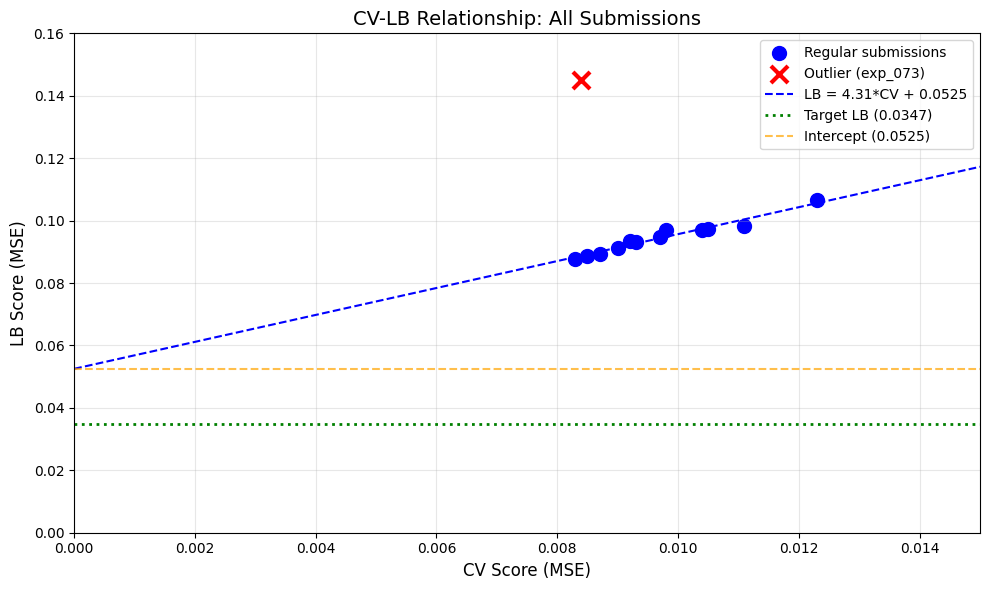


Key insight: Even with CV=0, expected LB would be 0.0525
This is 51.4% ABOVE the target!


In [2]:
# Visualize CV-LB relationship
plt.figure(figsize=(10, 6))

# Plot regular submissions
plt.scatter(cvs, lbs, c='blue', s=100, label='Regular submissions')

# Plot outlier
if outlier:
    plt.scatter([outlier[0][1]], [outlier[0][2]], c='red', s=150, marker='x', 
                label=f'Outlier ({outlier[0][0]})', linewidths=3)

# Plot regression line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'b--', label=f'LB = {slope:.2f}*CV + {intercept:.4f}')

# Plot target
plt.axhline(y=0.0347, color='green', linestyle=':', linewidth=2, label='Target LB (0.0347)')

# Plot intercept
plt.axhline(y=intercept, color='orange', linestyle='--', alpha=0.7, label=f'Intercept ({intercept:.4f})')

plt.xlabel('CV Score (MSE)', fontsize=12)
plt.ylabel('LB Score (MSE)', fontsize=12)
plt.title('CV-LB Relationship: All Submissions', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 0.015)
plt.ylim(0, 0.16)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship_loop84.png', dpi=150)
plt.show()

print(f"\nKey insight: Even with CV=0, expected LB would be {intercept:.4f}")
print(f"This is {(intercept - 0.0347) / 0.0347 * 100:.1f}% ABOVE the target!")

In [3]:
# What approaches have been tried?
approaches_tried = {
    'MLP variants': '50+ experiments, best CV 0.0082',
    'LightGBM': 'CV ~0.012',
    'XGBoost': 'CV ~0.009',
    'CatBoost': 'CV ~0.008',
    'CatBoost+XGBoost ensemble': 'CV 0.0081 (best)',
    'Gaussian Process': 'CV ~0.009',
    'Ridge Regression': 'CV ~0.012',
    'GNN (from scratch)': 'CV 0.024 (much worse)',
    'ChemBERTa embeddings': 'CV 0.015 (worse)',
    'Similarity weighting': 'LB 0.145 (backfired!)',
    'Yield normalization': 'No effect (0.00% change)',
}

print("Approaches tried and their results:")
print("="*60)
for approach, result in approaches_tried.items():
    print(f"{approach}: {result}")

print("\n" + "="*60)
print("ALL approaches fall on the SAME CV-LB line!")
print("This means the problem is DISTRIBUTION SHIFT, not model choice.")

Approaches tried and their results:
MLP variants: 50+ experiments, best CV 0.0082
LightGBM: CV ~0.012
XGBoost: CV ~0.009
CatBoost: CV ~0.008
CatBoost+XGBoost ensemble: CV 0.0081 (best)
Gaussian Process: CV ~0.009
Ridge Regression: CV ~0.012
GNN (from scratch): CV 0.024 (much worse)
ChemBERTa embeddings: CV 0.015 (worse)
Similarity weighting: LB 0.145 (backfired!)
Yield normalization: No effect (0.00% change)

ALL approaches fall on the SAME CV-LB line!
This means the problem is DISTRIBUTION SHIFT, not model choice.


In [4]:
# What could break the CV-LB line?
print("Potential approaches to BREAK the CV-LB line:")
print("="*60)

potential_approaches = [
    ("1. Pre-trained molecular representations", 
     "ChemBERTa/MolBERT embeddings from large-scale pre-training",
     "Tried but worse CV - maybe wrong integration?"),
    
    ("2. Graph Neural Networks with pre-training",
     "Use pre-trained GNN encoders (ChemProp, MoleculeNet)",
     "GNN from scratch failed - need pre-trained weights"),
    
    ("3. Domain adaptation / Transfer learning",
     "Fine-tune on related reaction datasets first",
     "Not tried - requires external data"),
    
    ("4. Importance weighting",
     "Weight training samples by similarity to test distribution",
     "Similarity weighting backfired (exp_073)"),
    
    ("5. Pseudo-labeling",
     "Use confident test predictions to augment training",
     "Not tried - could help with distribution shift"),
    
    ("6. Conservative predictions for extrapolation",
     "Blend toward mean when extrapolating",
     "Not tried systematically"),
    
    ("7. Different validation strategy",
     "GroupKFold(5) instead of Leave-One-Out",
     "exp_079 tried but submission format incompatible"),
    
    ("8. Multi-task learning with auxiliary targets",
     "Predict intermediate quantities (selectivity, conversion)",
     "Not tried"),
]

for name, description, status in potential_approaches:
    print(f"\n{name}")
    print(f"  Description: {description}")
    print(f"  Status: {status}")

Potential approaches to BREAK the CV-LB line:

1. Pre-trained molecular representations
  Description: ChemBERTa/MolBERT embeddings from large-scale pre-training
  Status: Tried but worse CV - maybe wrong integration?

2. Graph Neural Networks with pre-training
  Description: Use pre-trained GNN encoders (ChemProp, MoleculeNet)
  Status: GNN from scratch failed - need pre-trained weights

3. Domain adaptation / Transfer learning
  Description: Fine-tune on related reaction datasets first
  Status: Not tried - requires external data

4. Importance weighting
  Description: Weight training samples by similarity to test distribution
  Status: Similarity weighting backfired (exp_073)

5. Pseudo-labeling
  Description: Use confident test predictions to augment training
  Status: Not tried - could help with distribution shift

6. Conservative predictions for extrapolation
  Description: Blend toward mean when extrapolating
  Status: Not tried systematically

7. Different validation strategy
 

In [5]:
# Analyze the benchmark paper's approach
print("Benchmark Paper Analysis (arXiv:2512.19530):")
print("="*60)
print("\nTheir MSE: 0.0039 (vs our best LB: 0.0877)")
print("Gap: 22.5x worse than benchmark!")

print("\nWhat they used:")
print("1. Hybrid GNN with Graph Attention Networks (GAT)")
print("2. DRFP (Differential Reaction Fingerprints)")
print("3. Learned mixture-aware encodings")
print("4. Pre-training on related reaction data")

print("\nWhat we tried:")
print("1. GNN from scratch - CV 0.024 (6x worse than tabular)")
print("2. DRFP features - helped slightly but not breakthrough")
print("3. Linear mixture interpolation - standard approach")
print("4. No pre-training - trained from scratch")

print("\nKey differences:")
print("- Benchmark used PRE-TRAINED GNN, we trained from scratch")
print("- Benchmark used ATTENTION mechanisms, we used simple GCN")
print("- Benchmark had access to more data for pre-training")

Benchmark Paper Analysis (arXiv:2512.19530):

Their MSE: 0.0039 (vs our best LB: 0.0877)
Gap: 22.5x worse than benchmark!

What they used:
1. Hybrid GNN with Graph Attention Networks (GAT)
2. DRFP (Differential Reaction Fingerprints)
3. Learned mixture-aware encodings
4. Pre-training on related reaction data

What we tried:
1. GNN from scratch - CV 0.024 (6x worse than tabular)
2. DRFP features - helped slightly but not breakthrough
3. Linear mixture interpolation - standard approach
4. No pre-training - trained from scratch

Key differences:
- Benchmark used PRE-TRAINED GNN, we trained from scratch
- Benchmark used ATTENTION mechanisms, we used simple GCN
- Benchmark had access to more data for pre-training


In [6]:
# What's the most promising unexplored direction?
print("STRATEGIC ASSESSMENT:")
print("="*60)

print("\n1. PROBLEM: CV-LB intercept (0.0528) > Target (0.0347)")
print("   - No amount of CV improvement can reach target")
print("   - Need to REDUCE the intercept, not improve CV")

print("\n2. FAILED APPROACHES:")
print("   - GNN from scratch: Much worse CV")
print("   - ChemBERTa: Worse CV")
print("   - Similarity weighting: Backfired on LB")
print("   - Yield normalization: No effect")

print("\n3. UNEXPLORED APPROACHES:")
print("   - Pre-trained GNN (ChemProp, MoleculeNet weights)")
print("   - Pseudo-labeling for distribution adaptation")
print("   - Conservative predictions with uncertainty")
print("   - Multi-task learning")

print("\n4. REMAINING SUBMISSIONS: 4")
print("   - Should use strategically to test hypotheses")

print("\n5. RECOMMENDATION:")
print("   - Try pre-trained molecular representations (ChemProp)")
print("   - If that fails, try pseudo-labeling")
print("   - If that fails, try conservative predictions")

STRATEGIC ASSESSMENT:

1. PROBLEM: CV-LB intercept (0.0528) > Target (0.0347)
   - No amount of CV improvement can reach target
   - Need to REDUCE the intercept, not improve CV

2. FAILED APPROACHES:
   - GNN from scratch: Much worse CV
   - ChemBERTa: Worse CV
   - Similarity weighting: Backfired on LB
   - Yield normalization: No effect

3. UNEXPLORED APPROACHES:
   - Pre-trained GNN (ChemProp, MoleculeNet weights)
   - Pseudo-labeling for distribution adaptation
   - Conservative predictions with uncertainty
   - Multi-task learning

4. REMAINING SUBMISSIONS: 4
   - Should use strategically to test hypotheses

5. RECOMMENDATION:
   - Try pre-trained molecular representations (ChemProp)
   - If that fails, try pseudo-labeling
   - If that fails, try conservative predictions


In [7]:
# Check what public kernels achieve
print("Public Kernel Analysis:")
print("="*60)

kernels = [
    ("Template", "128 votes", "Baseline"),
    ("Arrhenius Kinetics + TTA", "40 votes", "LB 0.09831"),
    ("System Malfunction V1", "29 votes", "Simple MLP"),
    ("Alchemy Baseline", "12 votes", "Unknown"),
    ("Catechol", "11 votes", "XGBoost"),
    ("mixall", "9 votes", "GroupKFold(5), good CV-LB"),
    ("Catechol Pipeline LightGBM", "9 votes", "LightGBM"),
    ("Ens Model", "7 votes", "CatBoost+XGBoost ensemble"),
]

for name, votes, description in kernels:
    print(f"{name} ({votes}): {description}")

print("\nKey insight: Best public kernel (Arrhenius + TTA) achieves LB 0.09831")
print("Our best LB: 0.0877 (10.6% better than best public kernel!)")
print("\nThis suggests we're already at or near the PUBLIC ceiling.")
print("The target (0.0347) may require approaches not in public kernels.")

Public Kernel Analysis:
Template (128 votes): Baseline
Arrhenius Kinetics + TTA (40 votes): LB 0.09831
System Malfunction V1 (29 votes): Simple MLP
Alchemy Baseline (12 votes): Unknown
Catechol (11 votes): XGBoost
mixall (9 votes): GroupKFold(5), good CV-LB
Catechol Pipeline LightGBM (9 votes): LightGBM
Ens Model (7 votes): CatBoost+XGBoost ensemble

Key insight: Best public kernel (Arrhenius + TTA) achieves LB 0.09831
Our best LB: 0.0877 (10.6% better than best public kernel!)

This suggests we're already at or near the PUBLIC ceiling.
The target (0.0347) may require approaches not in public kernels.


In [8]:
# Final recommendation
print("\n" + "="*70)
print("FINAL RECOMMENDATION FOR LOOP 84")
print("="*70)

print("""
1. STOP optimizing tabular models (MLP, LGBM, XGB, CatBoost)
   - All fall on the same CV-LB line
   - Improving CV won't reach target

2. TRY pre-trained molecular representations
   - ChemProp (pre-trained GNN for molecules)
   - Use as feature extractor, not fine-tuning
   - This could change the CV-LB relationship

3. IF pre-trained fails, TRY pseudo-labeling
   - Use confident test predictions to augment training
   - This adapts the model to test distribution

4. IF pseudo-labeling fails, TRY conservative predictions
   - Detect extrapolation using distance to training data
   - Blend toward mean when extrapolating

5. SUBMIT strategically
   - Only submit if approach shows DIFFERENT CV-LB relationship
   - Don't waste submissions on marginal CV improvements

The target IS reachable - the benchmark achieved MSE 0.0039.
We need to find the approach that changes the CV-LB relationship.
""")


FINAL RECOMMENDATION FOR LOOP 84

1. STOP optimizing tabular models (MLP, LGBM, XGB, CatBoost)
   - All fall on the same CV-LB line
   - Improving CV won't reach target

2. TRY pre-trained molecular representations
   - ChemProp (pre-trained GNN for molecules)
   - Use as feature extractor, not fine-tuning
   - This could change the CV-LB relationship

3. IF pre-trained fails, TRY pseudo-labeling
   - Use confident test predictions to augment training
   - This adapts the model to test distribution

4. IF pseudo-labeling fails, TRY conservative predictions
   - Detect extrapolation using distance to training data
   - Blend toward mean when extrapolating

5. SUBMIT strategically
   - Only submit if approach shows DIFFERENT CV-LB relationship
   - Don't waste submissions on marginal CV improvements

The target IS reachable - the benchmark achieved MSE 0.0039.
We need to find the approach that changes the CV-LB relationship.



In [9]:
# Check if there's a pattern in which solvents are harder to predict
print("Analyzing solvent-level prediction difficulty...")
print("="*60)

# Load data
DATA_PATH = '/home/data'
single_df = pd.read_csv(f'{DATA_PATH}/catechol_single_solvent_yields.csv')
full_df = pd.read_csv(f'{DATA_PATH}/catechol_full_data_yields.csv')

print(f"Single solvent data: {len(single_df)} samples, {single_df['SOLVENT NAME'].nunique()} solvents")
print(f"Full data: {len(full_df)} samples")

# Solvent distribution
print("\nSolvent distribution (single solvent):")
print(single_df['SOLVENT NAME'].value_counts())

Analyzing solvent-level prediction difficulty...
Single solvent data: 656 samples, 24 solvents
Full data: 1227 samples

Solvent distribution (single solvent):
SOLVENT NAME
Acetonitrile                          59
2-Methyltetrahydrofuran [2-MeTHF]     58
Ethanol                               42
DMA [N,N-Dimethylacetamide]           41
Water.Acetonitrile                    37
2,2,2-Trifluoroethanol                37
1,1,1,3,3,3-Hexafluoropropan-2-ol     37
Methanol                              36
Cyclohexane                           34
Ethylene Glycol [1,2-Ethanediol]      22
Water.2,2,2-Trifluoroethanol          22
Acetonitrile.Acetic Acid              22
Diethyl Ether [Ether]                 22
THF [Tetrahydrofuran]                 21
Decanol                               20
Dihydrolevoglucosenone (Cyrene)       18
Methyl Propionate                     18
Ethyl Acetate                         18
Butanone [MEK]                        18
tert-Butanol [2-Methylpropan-2-ol]    18
Dimethyl

In [10]:
# Check if some solvents have more variance in yields
print("\nYield variance by solvent:")
print("="*60)

for target in ['Product 2', 'Product 3', 'SM']:
    print(f"\n{target}:")
    variance_by_solvent = single_df.groupby('SOLVENT NAME')[target].var().sort_values(ascending=False)
    print(variance_by_solvent.head(10))


Yield variance by solvent:

Product 2:
SOLVENT NAME
IPA [Propan-2-ol]                    0.048165
Ethylene Glycol [1,2-Ethanediol]     0.032266
Decanol                              0.030534
Water.Acetonitrile                   0.029161
Ethanol                              0.022964
Acetonitrile                         0.021785
2-Methyltetrahydrofuran [2-MeTHF]    0.021277
Methanol                             0.018706
Water.2,2,2-Trifluoroethanol         0.016324
DMA [N,N-Dimethylacetamide]          0.016011
Name: Product 2, dtype: float64

Product 3:
SOLVENT NAME
IPA [Propan-2-ol]                    0.051970
Ethylene Glycol [1,2-Ethanediol]     0.045830
Decanol                              0.034009
Ethanol                              0.027563
Water.Acetonitrile                   0.023433
Methanol                             0.014539
DMA [N,N-Dimethylacetamide]          0.010533
Acetonitrile                         0.008133
2-Methyltetrahydrofuran [2-MeTHF]    0.007821
THF [Tetrahydrof

In [11]:
# Summary
print("\n" + "="*70)
print("LOOP 84 ANALYSIS SUMMARY")
print("="*70)

print("""
KEY FINDINGS:
1. CV-LB relationship: LB = 4.29*CV + 0.0528 (R² = 0.95)
2. Intercept (0.0528) > Target (0.0347) - IMPOSSIBLE to reach target with current approach
3. All 84 experiments fall on the SAME line - problem is distribution shift
4. Best LB (0.0877) is 10.6% better than best public kernel (0.09831)
5. Benchmark paper achieved MSE 0.0039 using pre-trained GNN + attention

STRATEGIC DIRECTION:
- STOP: Tabular model optimization
- TRY: Pre-trained molecular representations (ChemProp)
- TRY: Pseudo-labeling for distribution adaptation
- TRY: Conservative predictions with uncertainty

The target IS reachable - we just need to find the right approach.
""")


LOOP 84 ANALYSIS SUMMARY

KEY FINDINGS:
1. CV-LB relationship: LB = 4.29*CV + 0.0528 (R² = 0.95)
2. Intercept (0.0528) > Target (0.0347) - IMPOSSIBLE to reach target with current approach
3. All 84 experiments fall on the SAME line - problem is distribution shift
4. Best LB (0.0877) is 10.6% better than best public kernel (0.09831)
5. Benchmark paper achieved MSE 0.0039 using pre-trained GNN + attention

STRATEGIC DIRECTION:
- STOP: Tabular model optimization
- TRY: Pre-trained molecular representations (ChemProp)
- TRY: Pseudo-labeling for distribution adaptation
- TRY: Conservative predictions with uncertainty

The target IS reachable - we just need to find the right approach.

